# 文章结构关系

### 关键词分布规律
* 科学论文是有显示结构的 Introduction, Conclusion

### 问题
- 新闻是否具有这种特性(结构性)，在开头结尾的词更加重要
- 还有什么其他体裁的内容


### 我的想法
- 利用位置信息找到word significance用来摘要（创新性不足）
- 建立多种词之间的关系，即多种SLN

## TODO
1. 绘制分布曲线，而不是散点图
2. 数据清洗工作
    - 变成小写字母
    - 移除标点符号
    - 移除数字
    - 移除低频词汇
3. 统计各个数据集的词数

## 科学论文的结构信息

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../code')

from psumm import preprocess_section
from eval_metric import rouge_perl
from functools import reduce

import corpus
from configparser import ConfigParser
    
config_file = "../config.ini"
config = ConfigParser()
config.optionxform=str
config.read(config_file)

corpora = list(getattr(corpus, name)(path) for name, path in config["Corpus"].items())

cnn, legal, sci,  acl, duc = corpora

In [2]:
%load_ext autoreload
%autoreload 2
#from code.data_loader import Corpus, tokenize, segment
from functools import partial
import matplotlib.pyplot as plt
#from metrics import rouge_score
import seaborn as sns
from psumm import preprocess_sentence

#tokenizer_ = partial(tokenize, remove_stop=True)
#corpus = Corpus(tokenizer_)
cut_tokenizer_ = lambda s: preprocess_sentence(s, remove_stop=True, stem=True).split(" ")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def proportion(item):
    abstract_words, intro_words, concl_words, sect_words = map(cut_tokenizer_,
        [item.abstract, item.introduction, item.conclusion, item.section])
    
    
    abstract_words = set(abstract_words)

    props = map(
        lambda words: len(list(filter(lambda w: w in abstract_words, words))) if len(words) != 0 else 0,
        [intro_words, concl_words, sect_words],
    )
    
    set_props = map(
        lambda words: len(list(filter(lambda w: w in abstract_words, words))) / len(words) if len(words) != 0 else 0,
        map(set, [intro_words, concl_words, sect_words]),
    )
    
    return list(props), list(set_props)

In [7]:
def mean(lst):
    lst = filter(lambda x: x != 0, lst)
    return sum(lst) / len(lst)


def plot_items(items, sort_key = None, scatter=True, save=None):
    pos_names = ["introduction", "conclusion", "section"]

    props, set_props = [{"introduction": [], "conclusion": [], "section": []} for _ in range(2)]
    proportions = map(proportion, items)
    if sort_key is not None: proportions = sorted(proportions, key=sort_key)
    
    for props_, set_props_ in proportions:
        for i, pos in enumerate(pos_names):
            props[pos].append(props_[i])
            set_props[pos].append(set_props_[i])
            
            
    fig = plt.figure(figsize=(10, 5))
    
    def plot_scatter():
        """
        Scatter
        """
        for i, (title, props_) in enumerate(zip(["proportion", "set_proportion"],
                                               [props, set_props]), 1):
            
            axis = fig.add_subplot(1, 2, i)
            axis.set_title(title)

            for pos, color, marker in zip(pos_names, ["green", "brown", "blue"], [".", "x", "+"]):
                axis.scatter(range(len(props_[pos])), props_[pos], label=pos, color=color, marker=marker)

            axis.legend(fontsize="xx-large")
    
    def plot_dist():
        """
        Distribution
        """
        for i, (title, props_) in enumerate(zip(["proportion", ""],#"set_proportion"],
                                               [props, set_props]), 1):
            if i == 1: continue
            
            axis = fig.add_subplot(1, 1, 1)
            axis.set_title(title)
            if i == 2:
                plt.xlim(0, 1)
            
            for pos, color in zip(pos_names, ["green", "brown", "blue"]):
                sns.distplot(props_[pos], label=pos, rug=False, hist=False, color=color, ax=axis)
            
            axis.legend(fontsize="xx-large")
        
    if scatter:
        plot_scatter()
    else:
        plot_dist()
    
    plt.show()
    
    if save:
        fig.savefig(save)


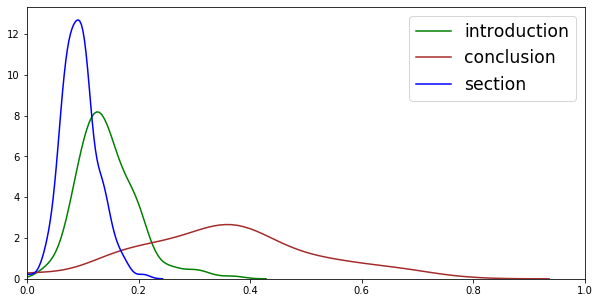

In [8]:
plot_items(acl.items_generator(), scatter=False, save="acl.png")

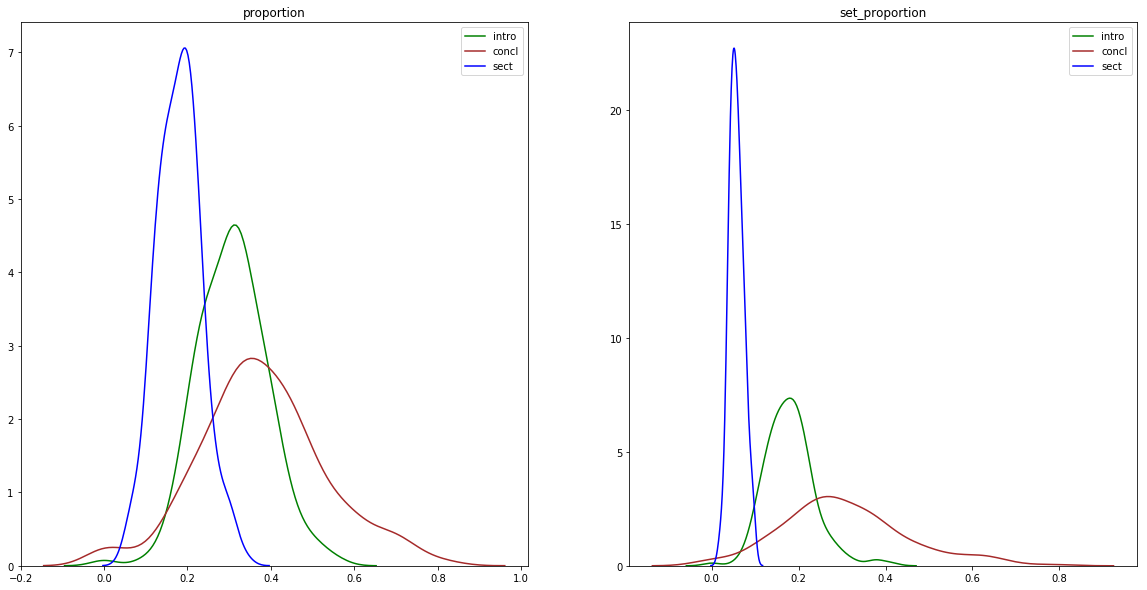

In [22]:
plot_items(corpus.items, scatter=False)

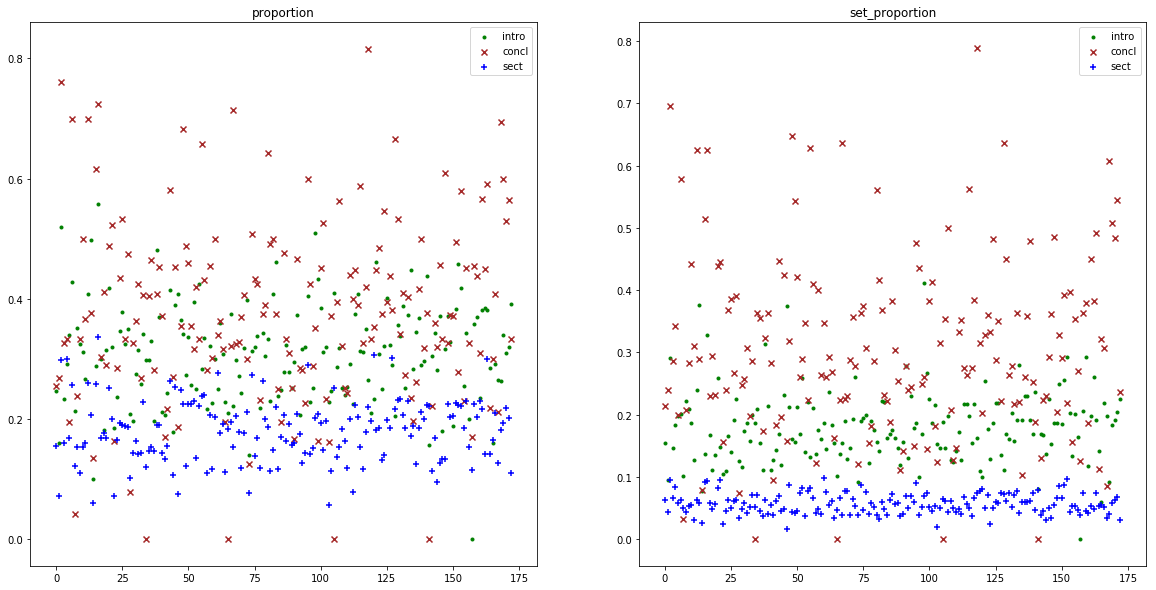

In [13]:
plot_items(corpus.items)

## 法律数据

法律语料，corpus目录
- cititions_summ
    - case的正文内容(<sentence>)
    - 描述的重要内容(<catchphrase>)
- full_text
    - case用id区分
    - case中包含的重要短语(<citphrase>)
- cititions_class/(暂时没用到)
    - 案例包含的case和文中附近的语句

In [23]:
from lxml import etree
from pathlib import Path

In [24]:
name = "06_1"
summ_file = Path(f"../data/corpus/citations_summ/{name}.xml")
summ_tree = etree.HTML(summ_file.read_text())
summ_tree.xpath("//citphrase//text()");

In [25]:
full_file = Path(f"../data/corpus/fulltext/{name}.xml")
full_tree = etree.HTML(full_file.read_text())
full_tree.xpath("//sentence//text()")
full_tree.xpath("//catchphrase//text()");

In [26]:
class LegalItem:
    
    def __init__(self, name):
        summ_tree = etree.HTML(Path(f"../data/corpus/citations_summ/{name}").read_text())
        full_tree = etree.HTML(Path(f"../data/corpus/fulltext/{name}").read_text())
        
        summ_phrases = summ_tree.xpath("//citphrase//text()")
        cite_phrases = full_tree.xpath("//catchphrase//text()")
        sentences = full_tree.xpath("//sentence//text()")
        self.sentences = sentences[:-2]
        
        self.abstract = " ".join(summ_phrases) + " " + " ".join(cite_phrases)
        self.introduction = sentences[:10]
        self.conclusion = sentences[:-10]
        self.sections = sentences[10:-10]
        
from collections import namedtuple

Item = namedtuple("Item", ["abstract", "introduction", "conclusion", "sections"])

In [27]:
names = list(map(lambda p: p.name, Path("../data/corpus/citations_summ/").glob("*.xml")))[:175]

In [28]:
litems = [LegalItem(name) for name in names]

SP, EP = 0.2, 0.1

def construct_item(litem):
    spos = int(SP * len(litem.sentences))
    epos = int(EP * len(litem.sentences))
    intro = litem.sentences[:spos]
    concl = litem.sentences[-epos:]
    sects = litem.sentences[spos:-epos]
    
    return Item(litem.abstract, *map(lambda ws: "".join(ws), [intro, concl, sects]))


items = list(map(construct_item, litems))

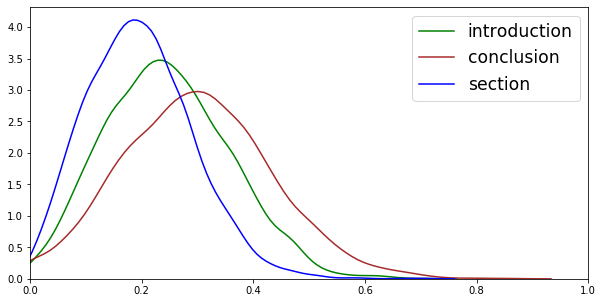

In [9]:
plot_items(legal.items_generator(), sort_key = lambda x: x[1][2], scatter=False, save="legal")

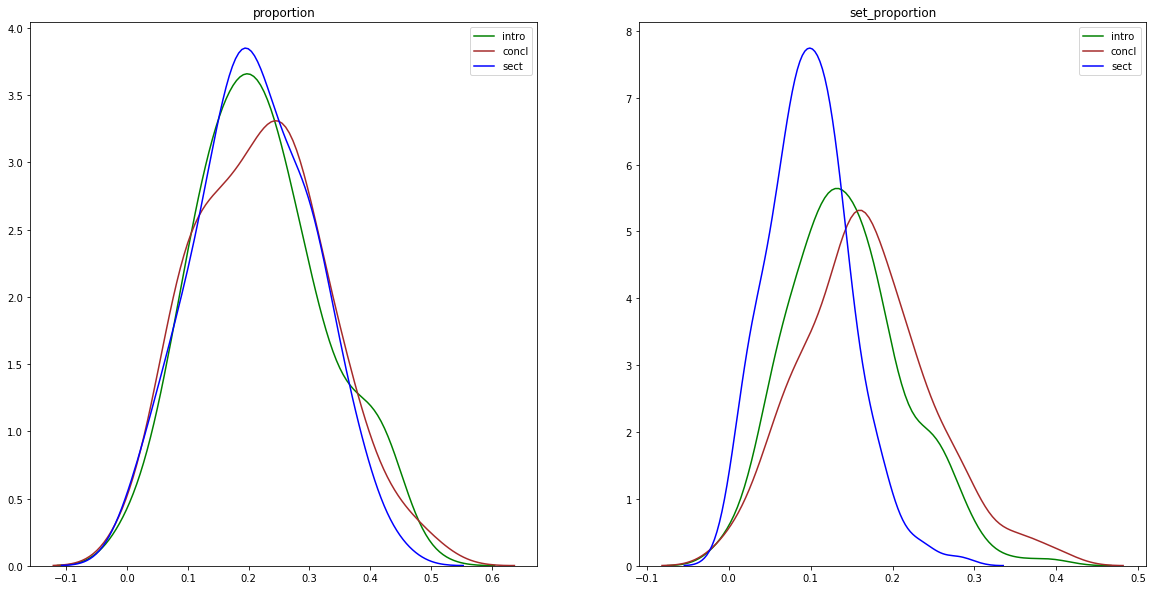

In [29]:
plot_items(items, sort_key = lambda x: x[1][2], scatter=False)

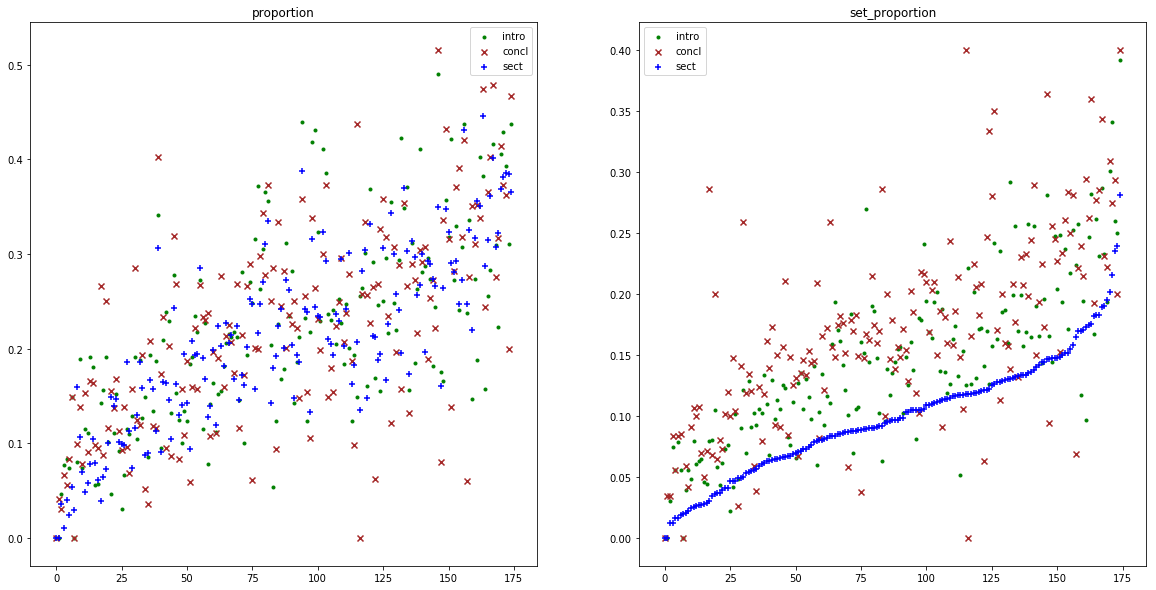

In [20]:
plot_items(items, sort_key = lambda x: x[1][2])

### 科技文档 ACL数据

* 文件夹scisumm-corpus
* 使用data/Training-Set-2019/Task2/From-ScisummNet-2019
    - 共977篇文章，868篇论文可用
    - 共84篇没有【ABSTRACT】标签
    - 共25篇不足3个section
    
    - 特别注意
        - N01-1008.xml 没有抽取中间章节

* TODO
    - 数据集的introduction和conclusion不是很好

In [36]:
from lxml import etree
from pathlib import Path
import re

names = list(map(lambda p: p.name, Path("../data/scisumm-corpus/data/Training-Set-2019/Task2/From-ScisummNet-2019/").glob("*")))[:175]

In [67]:
from itertools import chain
files = chain(*[(path / "Reference_XML").glob("*.xml") 
    for path in Path("../data/scisumm-corpus/data/Training-Set-2019/Task2/From-ScisummNet-2019/").iterdir()])

In [68]:
def build_item(file):
    tree = etree.HTML(file.read_text())
    
    abstract = "".join(tree.xpath("//abstract/s/text()"))
    if not abstract: 
        return "No <abstract>"
    
    sections = [( section.xpath("@title")[0], 
      "".join(section.xpath("s/text()")) ) for section in tree.xpath("//section")]
    
    sections = list(filter(lambda sec: sec[0] != "" and
           not re.search("(acknowledge?ment|reference|appendix|abstract)", sec[0].lower()), sections))
    
    if len(sections) < 3: 
        return "It needs more sections."
    
    introduction = conclusion = section_content = ""
    
    for title, content in sections:
        
        if re.search("(introduction|motivation|background)", title.lower()):
            introduction += content
        
        elif re.search("(conclust?ion|discussion|result|summary)", title.lower()):
            conclusion += content
        
        else:
            section_content += content
        
    if not introduction:
        introduction = ""#sections[0][1]
    if not conclusion:
        conclusion = ""#sections[-1][1]

    return Item(abstract, introduction, conclusion, section_content)

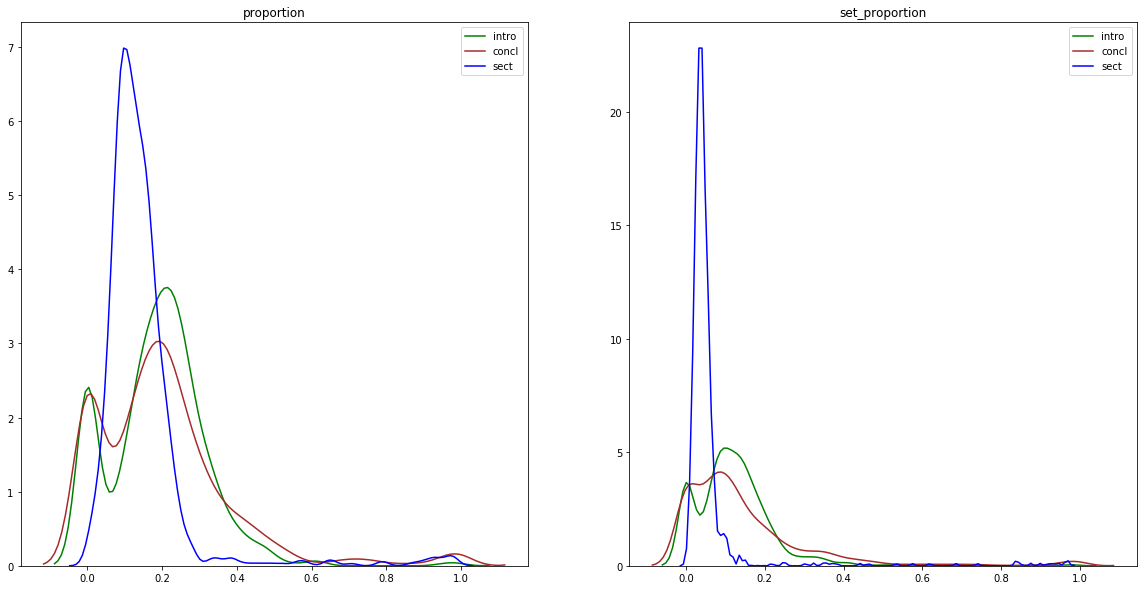

In [69]:
plot_items( list(filter(lambda x: isinstance(x, Item), list(map(build_item, files))))[:] , scatter=False")

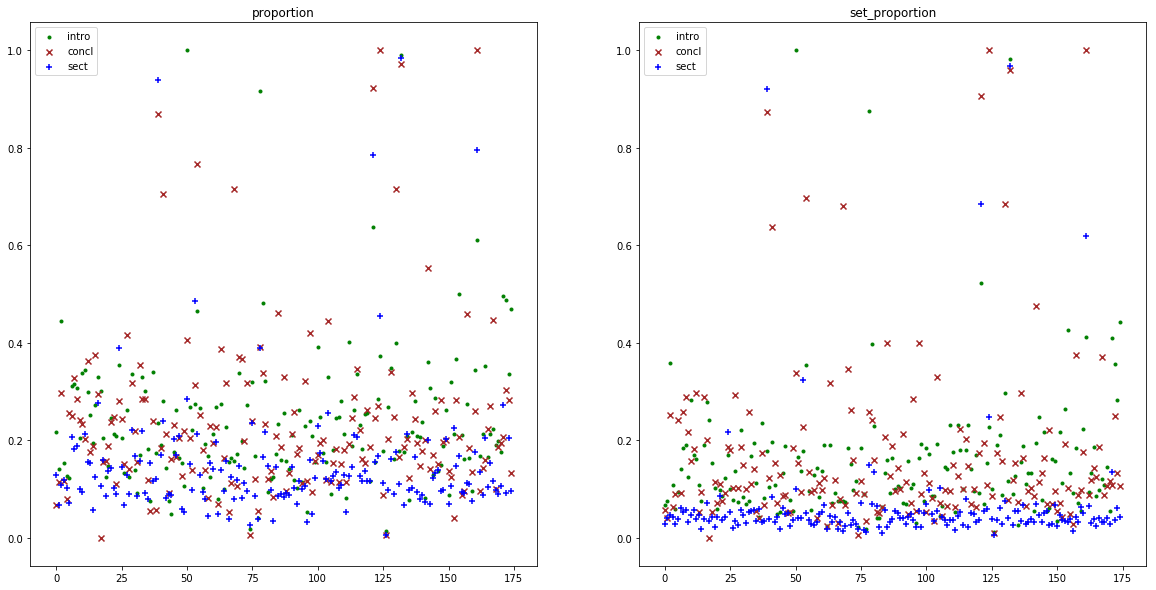

In [231]:
plot_items( list(filter(lambda x: isinstance(x, Item), list(map(build_item, files))))[:175] )

## CNN新闻数据

* 需要清洗导入数据
* 借助@highlight作为标准摘要

In [73]:
import string 

def split_story(file):
    content = file.read_text()
    idx = content.find("@highlight")
    story, hightlights = content[:idx], content[idx:].split("@highlight")
    return story.split("\n"), [h.strip() for h in hightlights if len(h) > 0]


def preprocess(lines):
    def _pre_line(line):
        idx = line.find("(CNN) -- ")
        if idx > -1:
            line = line[idx + len("(CNN)"):]
        
        words = line.lower().split()
        table = str.maketrans("", "", string.punctuation)
        words = [word.translate(table) for word in words]
        words = filter(lambda word: word.isalpha(), words)
    
        return " ".join(words)

    return list(filter(lambda l: len(l) > 0,
                            map(_pre_line, lines)))

items = []

for file in Path("../data/cnn/stories").glob("*.story"):
    story, highlights = map(preprocess, split_story(file))
    
    sent_count = len(story)
    
    intro_idx = int(0.3 * sent_count)
    conc_idx = int(0.1 * sent_count)
    
    item = Item(*map(lambda ls: " ".join(ls),
              (highlights, story[:intro_idx],  story[-conc_idx:],
               story[intro_idx:-conc_idx]) ))
    items.append(item)
                
    if len(items) == 1750: break

In [43]:
??corpus.CNN

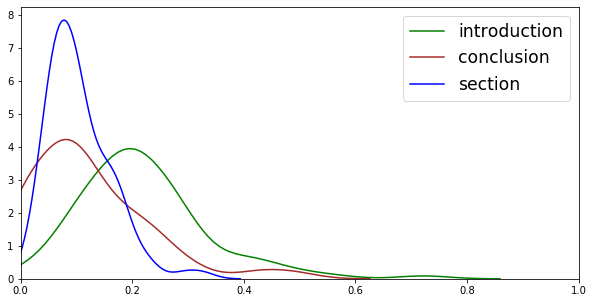

In [10]:
plot_items(list(cnn.items_generator())[:100], sort_key = lambda x: x[0][2], scatter=False, save="cnn")

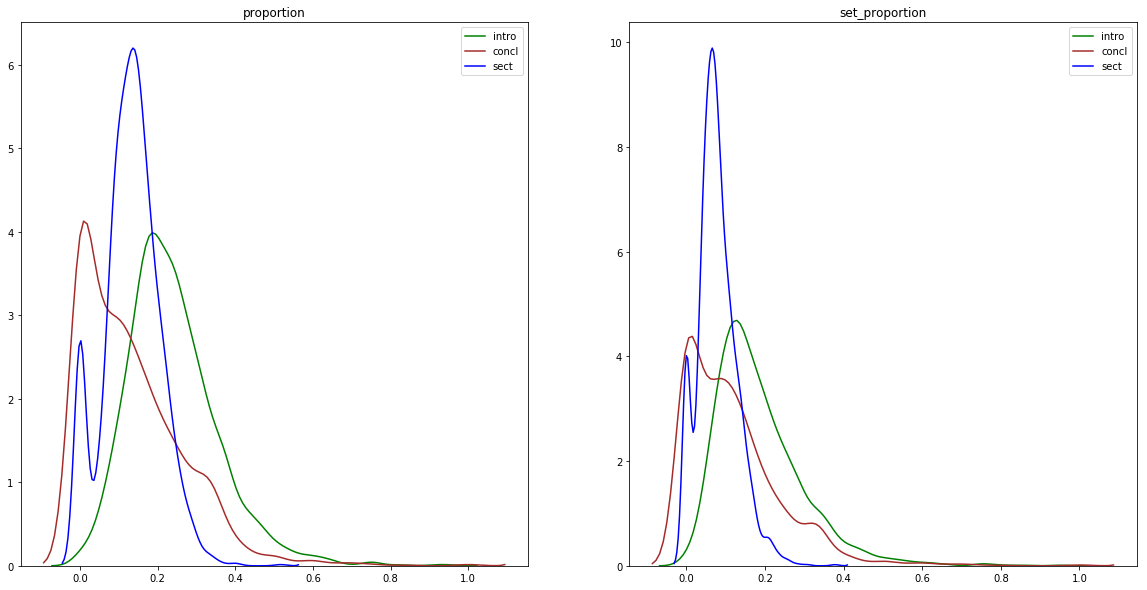

In [74]:
plot_items(items, sort_key = lambda x: x[0][2], scatter=False)

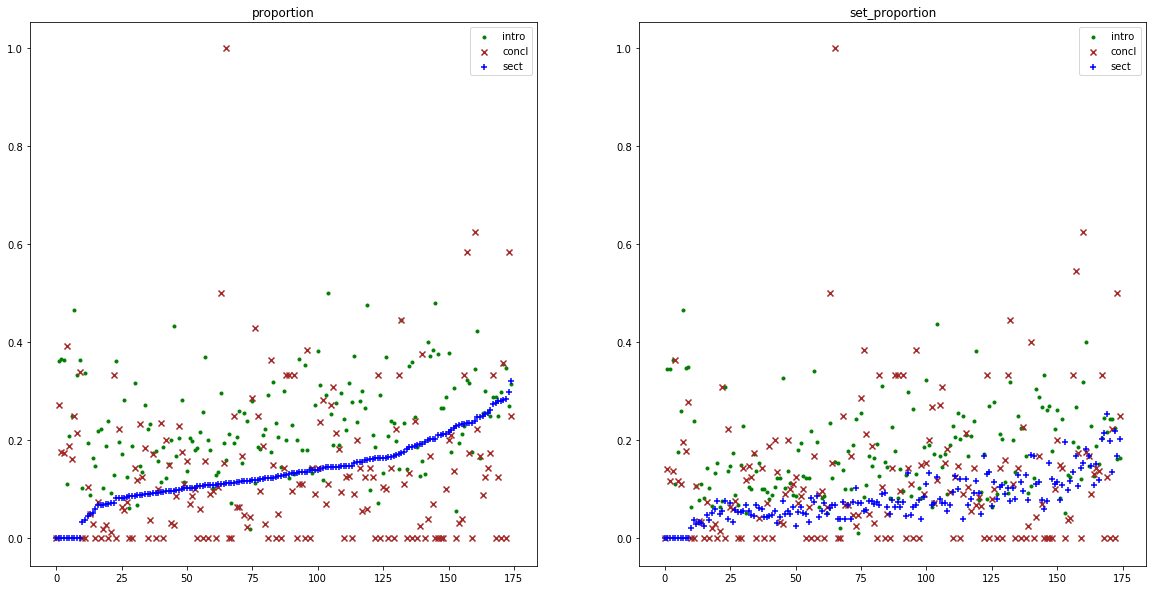

In [297]:
plot_items(items, sort_key = lambda x: x[0][2])

## BBC-news

In [303]:
list(Path("../data/bbc-news/BBC News Summary/News Articles/tech").iterdir())[0].name

'350.txt'

In [ ]:
cates = ["business", "entertainment", "politics", "sport", "tech"]

base_path = Path("../data/bbc-news/BBC News Summary")
article_path = base_path / "News Articles"
summary_path = base_path / "Summaries"


for file_path in (article_path / category).iterdir():
    article = (article_path / category / file_path.name).read_text()
    summary = (summary_path / category / file_path.name).read_text()
    
    article.split("\n")

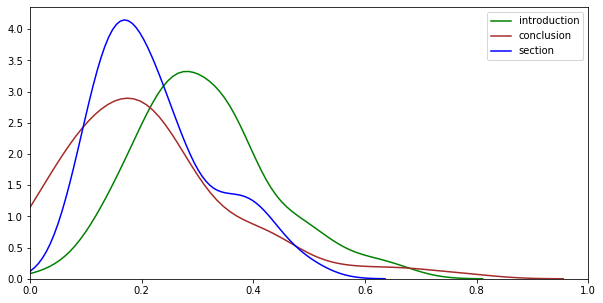

In [83]:
plot_items(list(duc.items_generator())[:100], sort_key = lambda x: x[0][2], scatter=False, save="duc")